In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

## This could be used to suggest a loan amount to maximise the likelihood of getting approval by using prediction model

## Import the Dataset (Reuse cleaned data)

In [2]:
data = pd.read_csv('cleaned_loan_data.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360,Y,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360,Y,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360,Y,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360,Y,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95,360,Y,Urban,Y


## Feature Selection

In [3]:
# Drop Loan_ID as they are not relevant for prediction
data.drop(columns=['Loan_ID'], inplace=True)
# Encode categorical variables
data = pd.get_dummies(data)

# Split features and target variable
X = data.drop(columns=['LoanAmount'])
y = data['LoanAmount']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          308 non-null    int64  
 1   CoapplicantIncome        308 non-null    float64
 2   LoanAmount               308 non-null    int64  
 3   Loan_Amount_Term         308 non-null    int64  
 4   Gender_Female            308 non-null    bool   
 5   Gender_Male              308 non-null    bool   
 6   Married_No               308 non-null    bool   
 7   Married_Yes              308 non-null    bool   
 8   Dependents_0             308 non-null    bool   
 9   Dependents_1             308 non-null    bool   
 10  Dependents_2             308 non-null    bool   
 11  Dependents_3+            308 non-null    bool   
 12  Education_Graduate       308 non-null    bool   
 13  Education_Not Graduate   308 non-null    bool   
 14  Self_Employed_No         3

## Create Model using Random Forest Regression as we want to predict a suitable loan amount

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Initialize and train RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=49)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=49)

## Model 1 (without any additional step)

Mean Squared Error: 509.5440
r^2 Score: 0.3718
Mean Absolute Error: 16.9068
Mean Absolute Percentage Error: 22.5731


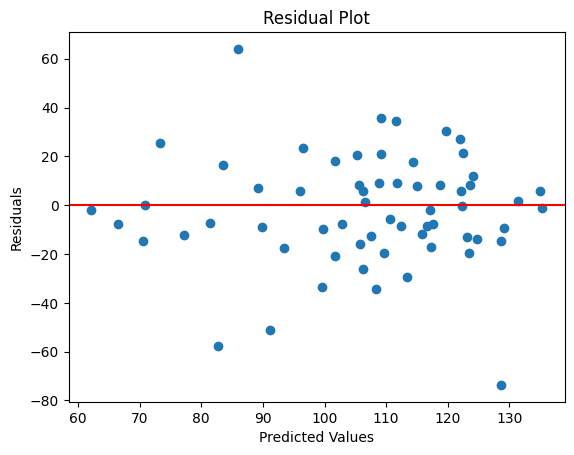

In [5]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
score = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse:.4f}')
print(f'r^2 Score: {score:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Absolute Percentage Error: {rmse:.4f}')

# Calculate residuals
residuals = y_test - y_pred

# Create residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Model 1 Result

The model/s performance does not appear to be very strong based on the 4 metrics. The R-squared score suggests that the model isn't  explaining much variance in the target variable.

# The performance of the model is not good enough, let's remove outliers from the data

In [6]:
def handle_outliers(data, columns):
    for col in columns:
        # Calculate quartiles
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define limits for removing outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

In [7]:
data = handle_outliers(data, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'])

X = data.drop(columns=['LoanAmount'])
y = data['LoanAmount']

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287 entries, 0 to 307
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          287 non-null    int64  
 1   CoapplicantIncome        287 non-null    float64
 2   LoanAmount               287 non-null    int64  
 3   Loan_Amount_Term         287 non-null    int64  
 4   Gender_Female            287 non-null    bool   
 5   Gender_Male              287 non-null    bool   
 6   Married_No               287 non-null    bool   
 7   Married_Yes              287 non-null    bool   
 8   Dependents_0             287 non-null    bool   
 9   Dependents_1             287 non-null    bool   
 10  Dependents_2             287 non-null    bool   
 11  Dependents_3+            287 non-null    bool   
 12  Education_Graduate       287 non-null    bool   
 13  Education_Not Graduate   287 non-null    bool   
 14  Self_Employed_No         287 no

Mean Squared Error: 595.8453
r^2 Score: 0.0750
Mean Absolute Error: 18.0714
Mean Absolute Percentage Error: 24.4099


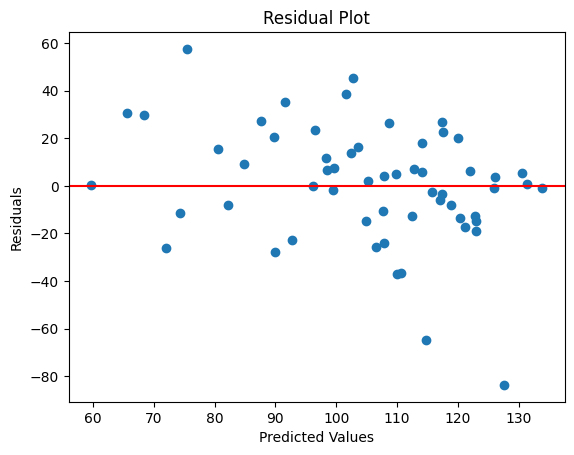

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
score = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse:.4f}')
print(f'r^2 Score: {score:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Absolute Percentage Error: {rmse:.4f}')

# Calculate residuals
residuals = y_test - y_pred

# Create residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Model 2 result

Removing outliers appears to have decreased the model's performance significantly, as indicated by the much lower R-sqaured score and higher MSE. So we will revert this change and try with k-fold cross validation to increase the performance.

# Now we will try k-fold cross-validation to improve the performance of the model

In [9]:
data = pd.read_csv('cleaned_loan_data.csv')
# Drop Loan_ID as they are not relevant for prediction
data.drop(columns=['Loan_ID'], inplace=True)
# Encode categorical variables
data = pd.get_dummies(data)

# Split features and target variable
X = data.drop(columns=['LoanAmount'])
y = data['LoanAmount']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          308 non-null    int64  
 1   CoapplicantIncome        308 non-null    float64
 2   LoanAmount               308 non-null    int64  
 3   Loan_Amount_Term         308 non-null    int64  
 4   Gender_Female            308 non-null    bool   
 5   Gender_Male              308 non-null    bool   
 6   Married_No               308 non-null    bool   
 7   Married_Yes              308 non-null    bool   
 8   Dependents_0             308 non-null    bool   
 9   Dependents_1             308 non-null    bool   
 10  Dependents_2             308 non-null    bool   
 11  Dependents_3+            308 non-null    bool   
 12  Education_Graduate       308 non-null    bool   
 13  Education_Not Graduate   308 non-null    bool   
 14  Self_Employed_No         3

Average Mean Squared Error across all folds: 624.7154
Average r^2 score across all folds: 0.2621
Average Mean Absolute Error (MAE) across all folds: 19.2786
Average Mean Absolute Percentage Error across all folds: 24.9861


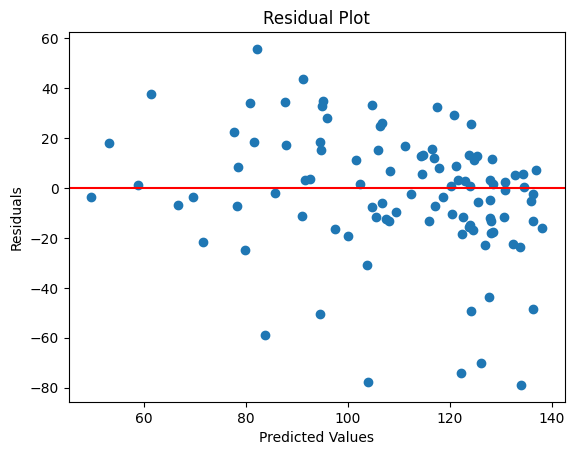

In [10]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

k = 3

kf = KFold(n_splits=k, shuffle=True, random_state=42)

mae_list = []
mse_list = []
score_list = []
rmse_list = []

# Iterate through each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets using the indices
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    score = model.score(X_test, y_test)
    rmse = np.sqrt(mse)
    
    # Store the MAE for this fold
    mae_list.append(mae)
    mse_list.append(mse)
    score_list.append(score)
    rmse_list.append(rmse)

# Calculate the average MAE across all folds
average_mae = sum(mae_list) / k
average_mse = sum(mse_list) / k
average_score = sum(score_list) / k
average_rmse = sum(rmse_list) / k



print(f'Average Mean Squared Error across all folds: {average_mse:.4f}')
print(f'Average r^2 score across all folds: {average_score:.4f}')
print(f'Average Mean Absolute Error (MAE) across all folds: {average_mae:.4f}')
print(f'Average Mean Absolute Percentage Error across all folds: {average_rmse:.4f}')

# Calculate residuals
residuals = y_test - y_pred

# Create residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Model 3 result

k-fold cross validation does not appear to be a good method too as the performance slightly decrease. Next, we will try tuning heperparameters to see if adjustments can imrpove the model performance.

## Tuning Hyperparameters

In [11]:
# Create a pipeline with preprocessing and model
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# Random Forest Regressor
rfr = RandomForestRegressor(random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2', 0.5]
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='neg_mean_absolute_error', error_score='raise')



# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(LinearRegression(), n_features_to_select=10)),  # Recursive Feature Elimination
    ('grid_search', grid_search)
])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
score = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse:.4f}')
print(f'r^2 Score: {score:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Absolute Percentage Error: {rmse:.4f}')

# Best hyperparameters found by GridSearchCV
best_params = pipeline.named_steps['grid_search'].best_params_
print(f'Best hyperparameters: {best_params}')

Mean Squared Error: 660.9574
r^2 Score: 0.8994
Mean Absolute Error: 19.9522
Mean Absolute Percentage Error: 25.7091
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


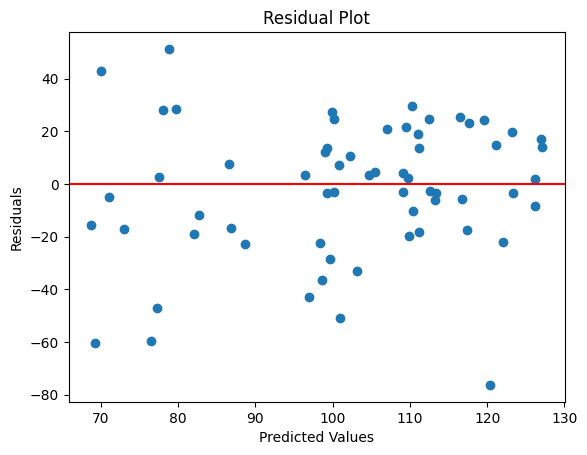

In [13]:
# Calculate residuals
residuals = y_test - y_pred

# Create residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Model 4 result

R-sqaured value of 0.8994 suggests that it is a strong model. Based on the grid-search method, the best hyperparameters are showed as {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

## Loan amount suggestion

Now we will use model 4 to suggest suitable loan amount for applicant to increase the likelihood of getting approval

In [14]:
feature_names = X.columns
print("Feature Names (Header):", feature_names)

Feature Names (Header): Index(['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term',
       'Gender_Female', 'Gender_Male', 'Married_No', 'Married_Yes',
       'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Graduate', 'Education_Not Graduate', 'Self_Employed_No',
       'Self_Employed_Yes', 'Credit_History_N', 'Credit_History_Y',
       'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban',
       'Loan_Status_N', 'Loan_Status_Y'],
      dtype='object')


## Prediction

In [17]:
new_data = pd.DataFrame({
    'ApplicantIncome': [4583],
    'CoapplicantIncome': [1508],
    'Loan_Amount_Term': [360],
    'Gender_Female': [0],
    'Gender_Male': [1],
    'Married_No': [0],
    'Married_Yes': [1],
    'Dependents_0': [0],
    'Dependents_1': [1],
    'Dependents_2': [0],
    'Dependents_3+': [0],
    'Education_Graduate': [1],
    'Education_Not Graduate': [0],
    'Self_Employed_No': [1],
    'Self_Employed_Yes': [0],
    'Credit_History_N': [0],
    'Credit_History_Y': [1],
    'Property_Area_Rural': [1],
    'Property_Area_Semiurban': [0],
    'Property_Area_Urban': [0],
    'Loan_Status_N': [0],
    'Loan_Status_Y': [1]
})

# Make prediction for new data
new_loan_amount = model.predict(new_data[feature_names])
print("Suggested Loan Amount to maximise the likelihood of getting approval:", new_loan_amount[0], "k ")

Suggested Loan Amount to maximise the likelihood of getting approval: 122.43 k 
